# Functions to be called throughout the code

In [1]:
def standardize(parameter):
    """
    :param parameter: the array with the parameters you wish to standardize
    :return param_mean: mean of the input array
    :return param_std : standard deviation of the input array
    :return stdized_param: final standardized array
    """
    import numpy as np
    
    param_mean    = np.mean(parameter)
    param_std     = np.std(parameter)
    stdized_param = []                  # standardized parameter -- output
    for i in range(parameter.size):
        param_temp = (parameter[i] - param_mean)/param_std
        stdized_param.append(param_temp)
    stdized_param = np.array(stdized_param)
    return (param_mean, param_std, stdized_param)

In [2]:
def un_standardize(stdized_par, mean, std):
    """
    This function undoes what the former does!
    """
    
    import numpy as np
    
    recovered_par = []
    for i in range(stdized_par.size):
        param_temp = stdized_par[i]*std + mean
        recovered_par.append(param_temp)
    recovered_par = np.array(recovered_par)
    return (recovered_par)

# Libraries

In [3]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import statsmodels.api   as sm
import seaborn           as sns
import pystan
import time

# Configuring the regression parameters

In [4]:
my_data = pd.read_csv('../../Catalogue/binom_reg_dataset.csv')

In [5]:
# filtering the dataset
redshifts = my_data['Z']
index     = np.where(redshifts.values<=0.4)

# parameters of interest
logit_class = my_data['LOGIT_CLASS(1-UVUP;0-UVWEAK)'].values[index].astype(int)    # y axis: logit class: UVUP yes/no
whan_class  = my_data['WHAN(0-NA;1-RP;2-wA;3-sA;4-SF)'].values[index].astype(int)  # My types of galaxies
mass        = my_data['STELLAR_MASS'].values[index].astype(int)                    # 1st parameter
redshift    = redshifts.values[index].astype(float)                                # 2nd parameter

In [6]:
# original parameters
mean_mass, std_mass, x2 = standardize(mass)
x1      = redshift
y       = logit_class
classes = (whan_class+1).astype(int)        # Must sum +1 to avoid index issues with STAN
n_obs   = x1.size
n_class = np.unique(classes).size

# new parameters - important for plotting!
n_obs2 = 30
x1_sim = np.linspace(x1.min(), x1.max(), n_obs2)
x2_sim = np.linspace(x2.min(), x2.max(), n_obs2)

# grid
plot_x1, plot_x2 = np.meshgrid(x1_sim, x2_sim)  # THIS IS WHERE THE GRID IS DONE
plot_x1 = plot_x1.reshape((n_obs2**2), 1)
plot_x2 = plot_x2.reshape((n_obs2**2), 1)

In [7]:
print x2.min(), x2.max() # sanity check
print np.median(x2)
print plot_x1.shape

-2.582215516074275 1.5690974667054223
-0.5065590246844265
(900, 1)


In [8]:
# dataset to be used in the regression
regression_data      = {}                                                 # Dictionary, as stated in the pystan manual
regression_data['Y'] = y
regression_data['X'] = sm.add_constant(np.column_stack((x1, x1**2, x2, x2**2)))
regression_data['K'] = regression_data['X'][0,:].size                     # Number of betas -- b0, b1, b2, b3, b4
regression_data['W'] = classes
regression_data['N'] = n_obs
regression_data['C'] = n_class                                      # Number of different classes (partial pooling)

# dataset to be used in the plot -- after meshgrid
regression_data['X2'] = sm.add_constant(np.column_stack((plot_x1, plot_x1**2, plot_x2, plot_x2)))
regression_data['N2'] = n_obs2**2

In [9]:
# Fit: STAN code ----------------------------------------------------------------------------------------------------------
stan_code = """
// DECLARATION OF VARIABLES -----------------------------------------------------------------------------------------------
data{
    int<lower=1> N;
    int<lower=1> N2;
    int<lower=1> K;
    int<lower=1> C;
    int W[N];
    int<lower=0, upper=1> Y[N];
    matrix[N, K] X;         // redshift and stellar mass 
    matrix[N2,K] X2;        // redshift and stellar mass -- after grid
    }

// DEFINING THE PRIOR(S) --------------------------------------------------------------------------------------------------
parameters{
    matrix[K,C] beta;       // 25 betas!
//    real<lower=0> sigma;    // Shared hyperpriors
//    real mu;                // Shared hyperpriors
    }

// MODEL: PROBABILITY, HYPERPRIORS, PRIORS, AND REGRESSION ----------------------------------------------------------------
model {
   vector[N] prob;
    for (i in 1:N) {
      prob[i] = beta[1,W[i]]*X[i,1] + beta[2,W[i]]*X[i,2] + beta[3,W[i]]*X[i,3] + beta[4,W[i]]*X[i,4] + 
      beta[5,W[i]]*X[i,5];
      }

//    sigma ~ gamma(0.001, 0.001);                           // shared hyperpriors
//    mu ~ normal(0, 100);                                   // shared hyperpriors
     
//    for (i in 1:K) {
//       for (j in 1:C) beta[i,j] ~ normal(mu, sigma);       // priors
//        }

    Y ~ bernoulli_logit(prob);                             // regression
    }

// DATA TO BE PLOTTED -----------------------------------------------------------------------------------------------------
generated quantities{
    vector[N2] prob01;
    vector[N2] eta01;
    vector[N2] prob02;
    vector[N2] eta02;
    vector[N2] prob03;
    vector[N2] eta03;
    vector[N2] prob04;
    vector[N2] eta04;
    vector[N2] prob05;
    vector[N2] eta05;
    
    for(j in 1:N2){
        eta01[j] = beta[1,1]*X2[j,1] + beta[2,1]*X2[j,2] + beta[3,1]*X2[j,3] + beta[4,1]*X2[j,4] + beta[5,1]*X2[j,5];
        eta02[j] = beta[1,2]*X2[j,1] + beta[2,2]*X2[j,2] + beta[3,2]*X2[j,3] + beta[4,2]*X2[j,4] + beta[5,2]*X2[j,5];
        eta03[j] = beta[1,3]*X2[j,1] + beta[2,3]*X2[j,2] + beta[3,3]*X2[j,3] + beta[4,3]*X2[j,4] + beta[5,3]*X2[j,5];
        eta04[j] = beta[1,4]*X2[j,1] + beta[2,4]*X2[j,2] + beta[3,4]*X2[j,3] + beta[4,4]*X2[j,4] + beta[5,4]*X2[j,5];
        eta05[j] = beta[1,5]*X2[j,1] + beta[2,5]*X2[j,2] + beta[3,5]*X2[j,3] + beta[4,5]*X2[j,4] + beta[5,5]*X2[j,5];
        prob01[j] = inv_logit(eta01[j]);
        prob02[j] = inv_logit(eta02[j]);
        prob03[j] = inv_logit(eta03[j]);
        prob04[j] = inv_logit(eta04[j]);
        prob05[j] = inv_logit(eta05[j]);
        }

    }

"""

### Settings for running STAN

In [10]:
iterations    = 7000
chains        = 3                           # HMC chains
warmup        = 2000                        # How many of the first iterations we'll ignore - burnin
jobs          = -1                          # Run code in parallel -- see pystan documentation
seed          = 1

In [11]:
control = {}
control['max_treedepth'] = 12
control['adapt_delta'] = 0.90

### The fit:

In [12]:
start = time.time()

fit = pystan.stan(model_code=stan_code, data=regression_data, seed=seed, iter=iterations, chains=chains, 
                  warmup=warmup, n_jobs=jobs, control=control)

end = time.time()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4694e14a049a0bc970b455befb90b231 NOW.
/home/mlldantas/anaconda3/envs/py2k7/lib/python2.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpX7Txcy/stanfit4anon_model_4694e14a049a0bc970b455befb90b231_6835527902848755546.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [13]:
print ("--------------------------------------------------")
print ("CPU process time: %.2f [min]" % float((end-start)/60))
print ("--------------------------------------------------")

--------------------------------------------------
CPU process time: 97.25 [min]
--------------------------------------------------


### Extracting fit properties

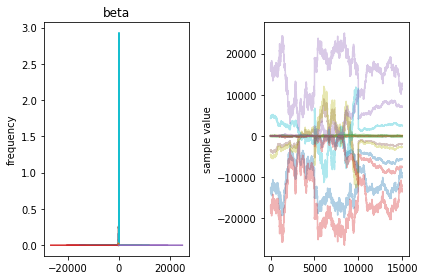

In [14]:
fit.plot('beta')
plt.tight_layout()
plt.show()

In [15]:
summary = pystan.stansummary(fit=fit, digits_summary=5)

In [16]:
summary_arr = np.array(summary.split('\n'))

In [17]:
new_output = summary_arr[5:-6,]                                                    # removing header and footer

In [18]:
print new_output[0]

beta[1,1]  -1.4662e1  1.2911 3.3211-2.1294e1-1.6691e1-1.5146e1-1.2906e1 -7.215    7.0 1.5471


## Formatting fit summary output

In [19]:
header_fit = summary_arr[4].split()
print header_fit

[u'mean', u'se_mean', u'sd', u'2.5%', u'25%', u'50%', u'75%', u'97.5%', u'n_eff', u'Rhat']


In [20]:
header_addendum = 'parameter'
header_fit = [header_addendum] + header_fit
print header_fit

['parameter', u'mean', u'se_mean', u'sd', u'2.5%', u'25%', u'50%', u'75%', u'97.5%', u'n_eff', u'Rhat']


In [26]:
cute_output = list(np.zeros(len(header_fit)))
for i in range(new_output.size):
    if len(new_output[i].split())!=11: # the length of the list must be 11, in which case we connect them directly
#         print "there is a problem!"
        print new_output[i]
    else:
        new_output_temp = np.array(new_output[i].split()).reshape(1,11)
        cute_output     = np.vstack((cute_output, new_output_temp))
cute_output = cute_output[1:,:]               # removing the zeroes in the beggining
print cute_output[:,0].shape

beta[1,1]  -1.4662e1  1.2911 3.3211-2.1294e1-1.6691e1-1.5146e1-1.2906e1 -7.215    7.0 1.5471
beta[2,1]  1.2191e2 1.184e13.093e15.5065e11.0594e21.2735e21.3935e21.8242e2    7.0 1.5271
beta[3,1]  -2.4891e22.6352e17.011e1-3.8338e2-2.8972e2-2.5794e2-2.1057e2-9.8862e1    7.0 1.4889
beta[2,2]  3.4932e1  7.17181.7821e1 8.97242.1221e13.2414e14.4896e17.8044e1    6.0 1.5700
beta[3,2]  -8.6182e11.9438e14.6783e1-1.9821e2-1.1148e2-7.9019e1-5.1055e1-1.7253e1    6.0 1.6018
beta[1,3]  -1.0039e43.5202e35.0542e3-1.8187e4-1.5009e4-7.7587e3-5.6202e3-3.5776e3    2.0 2.5229
beta[2,3]  -3.3904e11.8103e13.7138e1-1.0206e2-5.7488e1-3.5259e1 -8.2393.7587e1    4.0 1.7066
beta[3,3]  9.7612e15.3937e11.1112e2-1.1643e22.1532e19.7687e11.6951e23.0905e2    4.0 1.7067
beta[4,3]  -1.3423e44.7055e36.7561e3-2.4312e4-2.007e4-1.0372e4-7.5164e3-4.7926e3    2.0 2.5225
beta[5,3]  1.2633e44.4286e36.3584e34.5107e37.0745e39.7614e31.8889e42.2882e4    2.0 2.5225
beta[1,4]  -6.3776e21.0525e32.8962e3-7.0324e3-2.186e3-1.4088e38.1879e26.1

eta04[1]   -5.0895e28.3875e22.3077e3-5.6029e3-1.7417e3-1.1232e36.5079e24.9228e3    8.0 1.4289
eta04[2]   -5.0892e28.3876e22.3077e3-5.6027e3-1.7417e3-1.1232e36.507e24.9229e3    8.0 1.4289
eta04[3]   -5.0889e28.3877e22.3077e3-5.6026e3-1.7416e3-1.1232e36.5063e24.923e3    8.0 1.4289
eta04[4]   -5.0887e28.3878e22.3077e3-5.6024e3-1.7415e3-1.1232e36.5037e24.9231e3    8.0 1.4289
eta04[5]   -5.0885e28.3879e22.3077e3-5.6023e3-1.7413e3-1.1231e36.5016e24.9232e3    8.0 1.4289
eta04[6]   -5.0884e2 8.388e22.3077e3-5.6021e3-1.7412e3-1.123e36.4998e24.9233e3    8.0 1.4289
eta04[7]   -5.0883e2 8.388e22.3077e3-5.602e3-1.7412e3-1.123e36.4981e24.9234e3    8.0 1.4289
eta04[8]   -5.0882e28.3881e22.3077e3-5.602e3-1.7412e3-1.1229e36.4961e24.9234e3    8.0 1.4289
eta04[9]   -5.0883e28.3882e22.3077e3-5.6019e3-1.7412e3-1.1229e36.4941e24.9234e3    8.0 1.4289
eta04[10]  -5.0883e28.3882e22.3077e3-5.6018e3-1.7411e3-1.1228e36.4946e24.9235e3    8.0 1.4289
eta04[11]  -5.0885e28.3882e22.3077e3-5.6018e3-1.7411e3-1.1226e36.4

prob05[610] 0.0010     nan 0.0141    0.0    0.0    0.06.1951e-712.3912e-6    nan 1.0071
prob05[611] 0.0010     nan 0.0141    0.0    0.0    0.06.5535e-712.3586e-6    nan 1.0071
prob05[612] 0.0010     nan 0.0142    0.0    0.0    0.07.0116e-712.3813e-6    nan 1.0070
prob05[613] 0.0010     nan 0.0146    0.0    0.0    0.07.4917e-712.5582e-6    nan 1.0069
prob05[614] 0.0011     nan 0.0152    0.0    0.0    0.08.2517e-712.7069e-6    nan 1.0068
prob05[615] 0.0011     nan 0.0159    0.0    0.0    0.09.2986e-712.928e-6    nan 1.0068
prob05[616] 0.0012     nan 0.0169    0.0    0.0    0.01.0135e-703.192e-6    nan 1.0067
prob05[617] 0.0013     nan 0.0181    0.0    0.0    0.01.0996e-703.4311e-6    nan 1.0066
prob05[618] 0.0014     nan 0.0196    0.0    0.0    0.01.2246e-703.7244e-6    nan 1.0066
prob05[619] 0.0016     nan 0.0214    0.0    0.0    0.01.3953e-704.0978e-6    nan 1.0066
prob05[620] 0.0018     nan 0.0236    0.0    0.0    0.01.6178e-704.6375e-6    nan 1.0066
prob05[621] 0.0020     nan 0.0260 

# Saving the fit results

## Saving the probabilities separately for later

In [22]:
probability = {}
probability['prob01'] = list(fit.extract(u'prob01').items()[0])[1]
probability['prob02'] = list(fit.extract(u'prob02').items()[0])[1]
probability['prob03'] = list(fit.extract(u'prob03').items()[0])[1]
probability['prob04'] = list(fit.extract(u'prob04').items()[0])[1]
probability['prob05'] = list(fit.extract(u'prob05').items()[0])[1]

In [23]:
probability['prob01'].shape  # 21000 (3 x 7000) interations for a grid 30x30

(15000, 900)

In [24]:
start = time.time()
for i in range(n_class):
    prob_temp = probability['prob0%d' % int(i+1)]
    prob_tdf = pd.DataFrame(prob_temp)
    prob_tdf.to_csv('../../LargeFilesResults/rm_sharedprior_prob0%d.csv' % int(i+1))
end = time.time()
print ("--------------------------------------------------")
print ("CPU process time: %.2f [min]" % float((end-start)/60))
print ("--------------------------------------------------")

KeyboardInterrupt: 

 ## Extracting and saving the fit summary

In [ ]:
recovered_mass  = un_standardize(stdized_par=plot_x2, mean=mean_mass, std=std_mass)
rp      = np.column_stack((plot_x1, recovered_mass))
rp_cols = np.vstack((rp, rp, rp, rp, rp))       # for 5 whan classes we must stack these 5x

In [ ]:
parameters = cute_output[:,0].astype(str)
pnew_idxs  = []
for i in range(parameters.size):
    if parameters[i][0:4]=='prob':
        pnew_idxs.append(i)
    else:
        continue
print cute_output[pnew_idxs,:].shape, rp_cols.shape
model_results    = np.column_stack((cute_output[pnew_idxs,:], rp_cols))
model_results_df = pd.DataFrame(model_results)
model_results_df.columns = header_fit + ['Z'] + ['LOG_STELLAR_MASS']
model_results_df.to_csv('../../LargeFilesResults/fit_summary_rm_sharedprior.csv', header=True, index=False)

## Saving the posteriors

In [27]:
posteriors = list(fit.extract(u'beta').items()[0])[1]

In [28]:
print posteriors.shape

(15000, 5, 5)


In [29]:
matrix_row = posteriors[0,:,0].size  # rows are b0, b1, b2, b3, b4 -- posteriors given the regression
matrix_col = posteriors[0,0,:].size  # cols are w0, w1, w2, w3, w4 -- WHAN classification

In [30]:
betas_dict = {}
for line in range(matrix_row):
    for col in range(matrix_col):
        betas_dict["beta%d%d" % (line, col)] = posteriors[:, line, col]
betas_df = pd.DataFrame(betas_dict)

In [31]:
betas_df

,beta00,beta01,beta02,beta03,beta04,beta10,beta11,beta12,beta13,beta14,...,beta30,beta31,beta32,beta33,beta34,beta40,beta41,beta42,beta43,beta44
0,-12.841295,-3.150210,-7679.815617,-2290.611032,-88.633261,109.643090,29.030049,7.037636,3.166258,-18.078199,...,-0.655976,-0.010626,-10265.267465,-3058.783853,-120.490401,0.836811,0.077253,9661.107000,2878.654967,113.278577
1,-16.804677,-0.536977,-7586.912987,1467.632318,-61.537526,133.116853,8.164685,-15.960372,-39.020751,-20.112933,...,-0.285439,0.490694,-10143.107979,1959.526094,-83.952616,0.738570,-0.210363,9546.190186,-1844.513396,78.937924
2,-16.559330,-1.827309,-6465.945102,237.544550,-191.569055,137.939293,24.747278,-17.713914,-58.975154,-43.458364,...,-0.862551,0.404424,-8644.807114,311.644548,-260.616895,0.567431,-0.154296,8136.705046,-293.006947,244.939599
3,-14.683209,-2.657889,-5513.416020,307.025549,-120.814852,123.917563,27.938287,-11.834289,-64.320590,-44.890365,...,-1.005799,0.292300,-7370.761886,403.785809,-165.783328,0.597958,-0.127050,6937.237677,-378.302549,155.659017
4,-12.752903,-3.030315,-5926.078072,-2105.830788,-64.505205,105.950008,27.761217,6.198416,4.680511,-16.776908,...,-0.480435,0.151304,-7919.839108,-2812.299892,-87.157716,0.857110,0.098437,7454.373427,2646.102588,82.238016
5,-16.546727,-1.724387,-7931.834574,635.515388,-151.169386,136.999552,16.873358,-16.182296,-78.306539,-48.278665,...,-0.509731,0.273640,-10603.629187,840.818243,-206.829756,0.552864,-0.070431,9980.168346,-789.791933,194.777110
6,-13.147394,-3.189473,-5744.840744,-1849.853010,-14.441867,108.579659,29.889083,3.035471,-1.212260,-5.930903,...,-0.573867,0.069869,-7679.278127,-2471.795346,-18.374883,0.745023,0.079969,7227.671702,2327.076193,17.397450
7,-16.535487,-2.534132,-16500.460015,-2380.155810,-78.656572,141.849169,18.515392,-21.738963,2.481527,-36.246156,...,-0.389431,0.067240,-22061.583631,-3179.326435,-109.060304,0.705148,-0.027725,20763.820139,2992.900800,102.297385
8,-15.469354,-2.082748,-13723.064346,-2119.051116,-25.621721,127.504076,13.466073,-2.333966,-5.036251,-18.310934,...,-0.214731,0.009564,-18342.068838,-2830.864613,-35.861109,0.933165,-0.043845,17263.040654,2664.899120,33.841488
9,-17.048793,-1.739528,-12144.821371,-2523.496786,-21.765963,139.056105,10.302123,-7.831688,-17.345554,-9.773123,...,-0.270526,0.114685,-16235.199926,-3376.193880,-29.097189,0.816449,-0.132090,15280.114552,3179.096928,27.556161


In [32]:
betas_df.to_csv('./../../LargeFilesResults/betas_rm_sharedprior.csv', header=True, index=False)

## Saving the entire fit -- brace for impact!

In [33]:
start = time.time()
fit_df = fit.to_dataframe()
end = time.time()
print ("--------------------------------------------------")
print ("CPU process time: %.2f [min]" % float((end-start)/60))
print ("--------------------------------------------------")

MemoryError: 

In [ ]:
start = time.time()
fit_df.to_csv('../../LargeFilesResults/entirefit_rm_sharedpriors.csv', index=False)
end = time.time()
print ("--------------------------------------------------")
print ("CPU process time: %.2f [min]" % float((end-start)/60))
print ("--------------------------------------------------")

In [ ]:
fit_df.keys()

In [ ]:
fit_df

In [ ]:
chain_idx = fit_df['chain_idx'].values.astype(int)
chain     = fit_df['chain'].values.astype(int)
beta11    = fit_df['beta[1,1]'].values.astype(float)
beta12    = fit_df['beta[1,2]'].values.astype(float)
chain1    = np.where(chain==1)
chain2    = np.where(chain==2)
chain3    = np.where(chain==3)

In [ ]:
plt.subplots(figsize=(15,3))

plt.subplot(1,4,1)
sns.kdeplot(beta11[chain1], color='blue', alpha=0.6)
sns.kdeplot(beta11[chain2], color='orange', alpha=0.6)
sns.kdeplot(beta11[chain3], color='magenta', alpha=0.6)


plt.subplot(1,4,2)
plt.plot(chain_idx[chain1], beta11[chain1], color='blue', alpha=0.6)
plt.plot(chain_idx[chain2], beta11[chain2], color='orange', alpha=0.6)
plt.plot(chain_idx[chain3], beta11[chain3], color='magenta', alpha=0.6)

plt.subplot(1,4,3)
sns.kdeplot(beta12[chain1], color='blue', alpha=0.6)
sns.kdeplot(beta12[chain2], color='orange', alpha=0.6)
sns.kdeplot(beta12[chain3], color='magenta', alpha=0.6)


plt.subplot(1,4,4)
plt.plot(chain_idx[chain1], beta12[chain1], color='blue', alpha=0.8)
plt.plot(chain_idx[chain2], beta12[chain2], color='orange', alpha=0.6)
plt.plot(chain_idx[chain3], beta12[chain3], color='magenta', alpha=0.4)


plt.tight_layout()
plt.savefig('./Results/example_beta_traceplot_rmsharedprior.png')
plt.show()